Failed to clean /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1/3900543_Stade-de-Reims_1_45.json: Expecting ',' delimiter: line 1 column 138 (char 137)
Failed to clean /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1/3829430_Stade-de-Reims_1_57.json: Expecting ',' delimiter: line 1 column 211 (char 210)
Failed to clean /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1/3900512_Stade-de-Reims_1_59.json: Expecting ',' delimiter: line 1 column 177 (char 176)
Failed to clean /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1/3829436_Stade-de-Reims_0_52.json: Expecting ',' delimiter: line 1 column 177 (char 176)
Failed to clean /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1/3829482_Stade-de-Reims_1_63.json: Expecting ',' delimiter: line 1 column 140 (char 139)
Failed to clean /Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1/3829495_Stade-de-Reims_0_52.json: Expe

/var/folders/5p/rgqqft8n75g8hsgvyxs_bskh0000gn/T/ipykernel_87416/3385281969.py:64: DeprecationWarning: Call to deprecated class PersImage. (Replaced with the class `persim.PersistenceImager`.) -- Deprecated since version 0.1.5.
  pim = PersImage(pixels=pixels, spread=spread)  # Use 'pixels' instead of 'pixel_size'


PersImage(pixels=(20, 20), spread=1.0, specs=None, kernel_type="gaussian", weighting_type="linear")


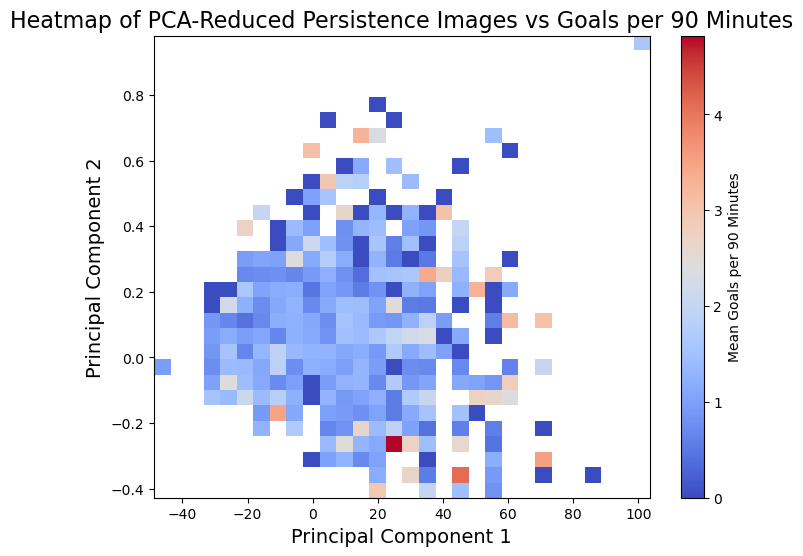

In [2]:
import os
import re
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ripser import ripser
from persim import PersImage
from scipy.stats import binned_statistic_2d


# Function to construct adjacency matrix
def construct_adjacency_matrix(game_data):
    G = nx.Graph()
    max_count = max(pass_info["count"] for player in game_data for pass_info in player["passes"])

    for player in game_data:
        G.add_node(player["name"], pos=(player["x"], player["y"]))

    for player in game_data:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = count / max_count
            G.add_edge(player1, player2, weight=edge_weight)

    return G


# Function to extract goals and time from file names
def extract_goals_and_time(file_name):
    match = re.search(r"_(\d+)_(\d+)\.json", file_name)
    if match:
        goals = int(match.group(1))
        time = int(match.group(2))
        return goals / time * 90  # Normalize to 90 minutes
    return 0


# Function to clean and validate JSON files
def clean_json(file_path):
    with open(file_path, "r") as f:
        raw_data = f.read()
    try:
        return json.loads(raw_data)
    except json.JSONDecodeError:
        # Attempt to fix common JSON issues
        fixed_data = raw_data.replace("\r", "").replace("\n", "").replace("\t", "").replace("\\", "")
        fixed_data = re.sub(r",\s*}", "}", fixed_data)  # Remove trailing commas before }
        fixed_data = re.sub(r",\s*\]", "]", fixed_data)  # Remove trailing commas before ]
        try:
            return json.loads(fixed_data)
        except json.JSONDecodeError as e:
            print(f"Failed to clean {file_path}: {e}")
            return None


# Function to convert persistence diagrams to persistence images
def convert_to_persistence_images(persistence_diagrams, pixels=(20, 20), spread=1.0):
    persistence_images = []
    pim = PersImage(pixels=pixels, spread=spread)  # Use 'pixels' instead of 'pixel_size'
    
    for diagram in persistence_diagrams:
        if diagram and len(diagram) > 0:
            # Only consider H1 (adjust based on requirements)
            persistence_image = pim.transform(diagram[1])  # Convert H1 persistence diagram
            persistence_images.append(persistence_image.flatten())  # Flatten the image
        else:
            # Handle empty diagrams
            persistence_images.append(np.zeros((pim.pixels[0] * pim.pixels[1],)))
    
    return np.array(persistence_images)



# Define folder paths
folder_paths = [
    "/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga",
    "/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/La-Liga",
    "/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Ligue-1",
    "/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Premier-League",
    "/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/Serie-A",
]

# Collect and clean data
file_paths = []
data = []
invalid_files = []

for folder in folder_paths:
    if os.path.exists(folder):
        for file_name in os.listdir(folder):
            if file_name.endswith(".json"):
                file_path = os.path.join(folder, file_name)
                cleaned_data = clean_json(file_path)
                if cleaned_data:
                    file_paths.append(file_path)
                    data.append(cleaned_data)
                else:
                    invalid_files.append(file_path)

# Log invalid files
if invalid_files:
    print(f"Skipped {len(invalid_files)} invalid files.")
    print("List of invalid files:")
    for invalid_file in invalid_files:
        print(invalid_file)

# Process valid data
persistence_diagrams = []
valid_file_paths = []

for file_path, match_data in zip(file_paths, data):
    try:
        G = construct_adjacency_matrix(match_data)
        adj_matrix = nx.to_numpy_array(G)
        diagrams = ripser(adj_matrix, distance_matrix=True)["dgms"]
        persistence_diagrams.append(diagrams)
        valid_file_paths.append(file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Extract persistence images from persistence diagrams
if persistence_diagrams:
    persistence_images = convert_to_persistence_images(persistence_diagrams)

    # Standardize persistence image features
    scaler = StandardScaler()
    persistence_images_scaled = scaler.fit_transform(persistence_images)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    persistence_images_pca = pca.fit_transform(persistence_images_scaled)

    # Extract goals per 90 minutes
    goals_per_90 = [extract_goals_and_time(os.path.basename(file_path)) for file_path in valid_file_paths]

    # Create a heatmap using PCA-transformed persistence images
    def plot_persistence_image_heatmap(features_pca, goals_per_90, bins=30):
        stat, x_edges, y_edges, binnumber = binned_statistic_2d(
            features_pca[:, 0], features_pca[:, 1], goals_per_90, statistic="mean", bins=bins
        )
        
        plt.figure(figsize=(8, 6))
        plt.imshow(
            stat.T,
            origin="lower",
            extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
            aspect="auto",
            cmap="coolwarm",
        )
        plt.colorbar(label="Mean Goals per 90 Minutes")
        plt.title("Heatmap of PCA-Reduced Persistence Images vs Goals per 90 Minutes", fontsize=16)
        plt.xlabel("Principal Component 1", fontsize=14)
        plt.ylabel("Principal Component 2", fontsize=14)
        plt.grid(False)
        plt.show()

    # Call the heatmap plotting function
    plot_persistence_image_heatmap(persistence_images_pca, goals_per_90)
else:
    print("No valid persistence diagrams were computed.")
